In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics

In [2]:
#read data
data_train=pd.read_csv('data_train\data_train.csv')
data_test=pd.read_csv('data_test\data_test.csv')
data_train.drop(['Unnamed: 0'],axis=1,inplace=True)
data_test.drop(['Unnamed: 0'],axis=1,inplace=True)

In [3]:
#transform data
x_upper = 3770901.5068
x_lower = 3750901.5068
y_upper = -19208905.6133 
y_lower = -19268905.6133
d_x=x_upper-x_lower
d_y=y_upper-y_lower
def transform_data(data):
    df=data.copy()
    df['x_entry']=x_lower-df['x_entry']
    df['y_entry']=y_lower-df['y_entry']
    df['x_exit']=x_lower-df['x_exit']
    df['y_exit']=y_lower-df['y_exit']
    df['time_entry']=pd.to_datetime(df['time_entry'])
    df['time_exit']=pd.to_datetime(df['time_exit'])
    return df
data_train=transform_data(data_train)
data_test =transform_data(data_test)
data_train.shape,data_test.shape

((814262, 11), (202937, 11))

In [4]:
#helper functions
def time_diff(x):
    t_x=np.array(x)
    return (t_x[-1]-t_x[0])/np.timedelta64(1, 'm')
def dist_diff(x):
    d_x=np.array(x)
    return (d_x[-1]-d_x[0])
def dist_x_endstart(x):
    d15_x=np.array(x)
    return d15_x[-1]
def is_center(x,d):
    if x<=0 and d+x>=0:
        return 1
    else:
        return 0    

In [5]:
def is_zero_dur(data):
    hash_group=data.groupby(['hash'])
    endtimedelta=(hash_group['time_exit'].apply(lambda x:np.array(x)[-1])-
                  hash_group['time_entry'].apply(lambda x:np.array(x)[-1]))/np.timedelta64(1, 'm') #last time duration
    p_time_duration=endtimedelta.to_frame(name='p_time_dur')
    data=pd.merge(data,p_time_duration,left_on='hash',right_index=True,how='inner')
    data_z=data[data.p_time_dur==0]
    data_nz=data[data.p_time_dur!=0]
    return data_z,data_nz

In [167]:
data_train_z,data_train_nz=is_zero_dur(data_train)
data_test_z,data_test_nz=is_zero_dur(data_test)
data_train_z.shape,data_train_nz.shape,data_test_z.shape,data_test_nz.shape

((391381, 12), (422881, 12), (98349, 12), (104588, 12))

#  时间间隔为0的预测

In [168]:
def zero_dur_prediction(data):
    df=data.copy()
    hash_group=df.groupby(['hash'])
    endstart_x=hash_group['x_entry'].apply(lambda x:dist_x_endstart(x)) #start location x
    endstart_y=hash_group['y_entry'].apply(lambda x:dist_x_endstart(x)) #start location y
    end_x=endstart_x.to_frame(name='end_x')
    end_y=endstart_y.to_frame(name='end_y')
    df=pd.merge(df,end_x,left_on='hash',right_index=True,how='inner')
    df=pd.merge(df,end_y,left_on='hash',right_index=True,how='inner')
    df.loc[:,'is_in_center_x']=df.loc[:,'end_x'].apply(lambda x:is_center(x,d_x))
    df.loc[:,'is_in_center_y']=df.loc[:,'end_y'].apply(lambda y:is_center(y,d_y))
    df['label']= np.array(df['is_in_center_x']) & np.array(df['is_in_center_y'])
    return df

In [169]:
dftrain_z=zero_dur_prediction(data_train_z)
dftest_z=zero_dur_prediction(data_test_z)

In [170]:
dframe_test_z=dftest_z.drop(['trajectory_id','time_entry',
                  'time_exit','vmax','vmin','vmean','x_entry','y_entry',
                  'x_exit','y_exit'],axis=1)
dframe_test_z=dframe_test_z.drop_duplicates()
y_pred_z=dframe_test_z['label']
gb_z=dftest_z.groupby(['hash'])
last_id_z=gb_z['trajectory_id'].apply(lambda x:np.array(x)[-1])
result_z=pd.Series(y_pred_z.values,index=last_id_z.values)
result_z.to_frame(name='center_city')
result_z.to_csv('result_9_1.csv')

# 时间间隔非0的预测

In [171]:
def feature_engineering(data):
    df=data.copy()
    #groupby each tarjectory
    hash_group=df.groupby(['hash'])
    difftime=hash_group['time_entry'].apply(lambda x:time_diff(x)) #time duration
    dist_x=hash_group['x_entry'].apply(lambda x:dist_diff(x)) #distance of direction x
    dist_y=hash_group['y_entry'].apply(lambda y:dist_diff(y)) #distance of direction y
    endstart_x=hash_group['x_entry'].apply(lambda x:dist_x_endstart(x)) #start location x
    endstart_y=hash_group['y_entry'].apply(lambda x:dist_x_endstart(x)) #start location y
    endtimedelta=(hash_group['time_exit'].apply(lambda x:np.array(x)[-1])-
               hash_group['time_entry'].apply(lambda x:np.array(x)[-1]))/np.timedelta64(1, 'm') #last time duration
    start_time_hour=hash_group['time_entry'].apply(lambda x:np.array(x.dt.hour)[0])
    id_count=hash_group['trajectory_id'].count()
    
    feat=[difftime,dist_x,dist_y,endstart_x,
          endstart_y,endtimedelta,start_time_hour,id_count]
    for i,x in enumerate(feat):
        feats=x.to_frame(name='feature_'+str(i+1))
        df=pd.merge(df,feats,left_on='hash',right_index=True,how='inner')
    
    df['vel_x']=df['feature_2']/df['feature_1']
    df['vel_y']=df['feature_3']/df['feature_1']
    
    df_1=df[df['feature_8']==1]
    df_2=df[df['feature_8']>1]
    df_1.loc[:,'pre_v1_x']=df_1.loc[:,'vel_x']
    df_1.loc[:,'pre_v1_y']=df_1.loc[:,'vel_y'] 
    
    h_gb=df_2.groupby(['hash'])
    now1t=h_gb['time_entry'].apply(lambda x:np.array(x)[-1])
    pre1t=h_gb['time_exit'].apply(lambda x:np.array(x)[-2])
    now1x=h_gb['x_entry'].apply(lambda x:np.array(x)[-1])
    pre1x=h_gb['x_exit'].apply(lambda x:np.array(x)[-2])
    now1y=h_gb['y_entry'].apply(lambda x:np.array(x)[-1])
    pre1y=h_gb['y_exit'].apply(lambda x:np.array(x)[-2])
    delta1t= (now1t-pre1t)/np.timedelta64(1, 'm')
    pre_distx=now1x-pre1x
    pre_disty=now1y-pre1y
    pre_vel_x=pre_distx/delta1t
    pre_vel_y=pre_disty/delta1t
    df2_feat1=pre_vel_x.to_frame(name='pre_v1_x')
    df2_feat2=pre_vel_y.to_frame(name='pre_v1_y')
    df_2=pd.merge(df_2,df2_feat1,left_on='hash',right_index=True,how='inner')
    df_2=pd.merge(df_2,df2_feat2,left_on='hash',right_index=True,how='inner')
    
    df=df_1.append(df_2)
    
    df.loc[:,'is_in_center_x']=df.loc[:,'feature_4'].apply(lambda x:is_center(x,d_x))
    df.loc[:,'is_in_center_y']=df.loc[:,'feature_5'].apply(lambda y:is_center(y,d_y))
    return df

In [172]:
df_train_nz=feature_engineering(data_train_nz)
df_test_nz =feature_engineering(data_test_nz)

C:\Users\Liu Qiong\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Liu Qiong\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [173]:
df_train_nz.columns

Index(['hash', 'trajectory_id', 'time_entry', 'time_exit', 'vmax', 'vmin',
       'vmean', 'x_entry', 'y_entry', 'x_exit', 'y_exit', 'p_time_dur',
       'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'vel_x', 'vel_y', 'pre_v1_x',
       'pre_v1_y', 'is_in_center_x', 'is_in_center_y'],
      dtype='object')

In [15]:
#df_test.sort_index(inplace=True)
df_train_nz.head()

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,feature_8,vel_x,vel_y,is_in_center_x,is_in_center_y,exit_x,exit_y,label_x,label_y,label
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,2019-04-11 07:04:31,2019-04-11 07:08:32,NaN,NaN,NaN,-112.262606,-174924.969304,575.691847,...,6,12.696943,392.998333,0,0,6116.062904,12572.734471,0,0,0
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,2019-04-11 07:20:34,2019-04-11 07:25:42,NaN,NaN,NaN,6964.317424,53561.934028,5926.819770,...,6,12.696943,392.998333,0,0,6116.062904,12572.734471,0,0,0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,2019-04-11 07:53:32,2019-04-11 08:03:25,NaN,NaN,NaN,6033.686481,24659.310214,6086.006642,...,6,12.696943,392.998333,0,0,6116.062904,12572.734471,0,0,0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,2019-04-11 08:17:50,2019-04-11 08:37:23,NaN,NaN,NaN,6021.441337,23384.151345,6092.685811,...,6,12.696943,392.998333,0,0,6116.062904,12572.734471,0,0,0
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,2019-04-11 14:38:09,2019-04-11 14:38:09,NaN,NaN,NaN,5992.498269,16679.383523,5992.498269,...,6,12.696943,392.998333,0,0,6116.062904,12572.734471,0,0,0


In [174]:
#train_dataset label
hash_group=df_train_nz.groupby(['hash'])
endexit_x=hash_group['x_exit'].apply(lambda x:dist_x_endstart(x))
endexit_y=hash_group['y_exit'].apply(lambda x:dist_x_endstart(x))
exit_x=endexit_x.to_frame(name='exit_x')
exit_y=endexit_y.to_frame(name='exit_y')
df_train_nz=pd.merge(df_train_nz,exit_x,left_on='hash',right_index=True,how='inner')
df_train_nz=pd.merge(df_train_nz,exit_y,left_on='hash',right_index=True,how='inner')
df_train_nz['label_x']=df_train_nz.loc[:,'exit_x'].apply(lambda x:is_center(x,d_x))
df_train_nz['label_y']=df_train_nz.loc[:,'exit_y'].apply(lambda y:is_center(y,d_y))
df_train_nz['label']= np.array(df_train_nz['label_x']) & np.array(df_train_nz['label_y'])

In [175]:
def generate_dataset(data):
    df=data.drop(['trajectory_id','time_entry',
                  'time_exit','vmax','vmin','vmean','x_entry','y_entry','p_time_dur',
                  'x_exit','y_exit'],axis=1)
    df=df.drop_duplicates()
    return df

In [176]:
dframe_train_nz=generate_dataset(df_train_nz)
dframe_test_nz=generate_dataset(df_test_nz)

In [59]:
dframe_train_nz.shape,dframe_test_nz.shape

((67065, 20), (16674, 15))

In [60]:
dframe_train_nz.columns

Index(['hash', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'vel_x', 'vel_y', 'pre_v1_x',
       'pre_v1_y', 'is_in_center_x', 'is_in_center_y', 'exit_x', 'exit_y',
       'label_x', 'label_y', 'label'],
      dtype='object')

In [61]:
dframe_test_nz.columns

Index(['hash', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'vel_x', 'vel_y', 'pre_v1_x',
       'pre_v1_y', 'is_in_center_x', 'is_in_center_y'],
      dtype='object')

In [192]:
X=dframe_train_nz[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 
        'feature_7', 
        'feature_8', 
        #'vel_x', 'vel_y',
       'pre_v1_x','pre_v1_y'
       #'is_in_center_x', 'is_in_center_y'
                  ]]
y=dframe_train_nz['label']
X_t=dframe_test_nz[['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 
        'feature_7', 
        'feature_8', 
        #'vel_x', 'vel_y', 
       'pre_v1_x','pre_v1_y'
       #'is_in_center_x', 'is_in_center_y'
                   ]]

In [193]:
# split dataset into two
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=444)

In [179]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((50298, 14), (16767, 14), (50298,), (16767,))

In [197]:
model1=xgb.XGBClassifier(n_estimators=100,
                         max_depth=8,
                         learning_rate=0.2,
                         gamma=0.1,
                         early_stopping_rounds=3)
model1.fit(X_train,y_train,eval_metric='error',eval_set=[(X_test,y_test)],verbose=True)

[0]	validation_0-error:0.132701
[1]	validation_0-error:0.131389
[2]	validation_0-error:0.129361
[3]	validation_0-error:0.127333
[4]	validation_0-error:0.127811
[5]	validation_0-error:0.126916
[6]	validation_0-error:0.127095
[7]	validation_0-error:0.126618
[8]	validation_0-error:0.125485
[9]	validation_0-error:0.125127
[10]	validation_0-error:0.124709
[11]	validation_0-error:0.124411
[12]	validation_0-error:0.123874
[13]	validation_0-error:0.123576
[14]	validation_0-error:0.122443
[15]	validation_0-error:0.122204
[16]	validation_0-error:0.122503
[17]	validation_0-error:0.121966
[18]	validation_0-error:0.121727
[19]	validation_0-error:0.121429
[20]	validation_0-error:0.121906
[21]	validation_0-error:0.122562
[22]	validation_0-error:0.121727
[23]	validation_0-error:0.121727
[24]	validation_0-error:0.12125
[25]	validation_0-error:0.121012
[26]	validation_0-error:0.120534
[27]	validation_0-error:0.120594
[28]	validation_0-error:0.120296
[29]	validation_0-error:0.120415
[30]	validation_0-err

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=3, gamma=0.1,
       learning_rate=0.2, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

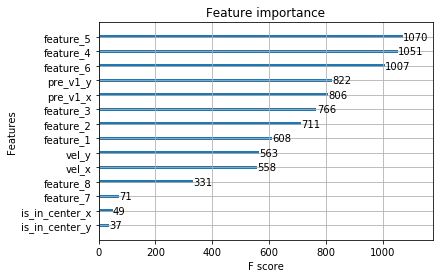

In [181]:
xgb.plot_importance(model1)
plt.show()

In [198]:
y_pred=model1.predict(X_test)
from sklearn import metrics
accuracy_rate=metrics.accuracy_score(y_test,y_pred)
accuracy_rate

0.88024094948410569

In [158]:
gb=data_test_nz.groupby(['hash'])
last_id=gb['trajectory_id'].apply(lambda x:np.array(x)[-1])
y_t=model1.predict(X_t)
result=pd.Series(y_t,index=last_id.values)
result.to_frame(name='city_center')
result.to_csv('result11_2.csv')

In [15]:
X.shape,X_t.shape,X_a.shape

((134063, 12), (33515, 12), (167578, 12))

In [166]:
#SVM
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_a=X.append(X_t)
X_a=X_a.fillna(0)
scaler = StandardScaler()
X_std = scaler.fit_transform(X_a)
X_train=X_std[:X.shape[0]]
X_test=X_std[X.shape[0]:]
x_train, x_test, y_train, y_test=train_test_split(X_train,y,test_size=0.3,random_state=444)
svc = SVC(kernel='rbf',C=1,gamma='auto',degree=4,class_weight='balanced')
clf = svc.fit(x_train, y_train)
score = svc.score(x_test, y_test)
print('精度为%s' % score)

精度为0.802982107356


In [23]:
y_pred=svc.predict(X_test)
y_pred.shape

(33515,)

In [25]:
gb=data_test.groupby(['hash'])
last_id=gb['trajectory_id'].apply(lambda x:np.array(x)[-1])
result=pd.Series(y_pred,index=last_id.values)
result.to_frame(name='city_center')
result.to_csv('result7.csv')